In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from scipy.sparse import csr_matrix

In [2]:
import os
import tqdm

path = '/mounts/data/proj/asgari/dissertation/datasets/deepbio/taxonomy/ncbi-blast-2.5.0+/bin/'
os.environ['PATH'] += ':'+path
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

def is_not_too_ambiguous(results):
    levels_id={'Superkingdom':1,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}
    
    species=set([x[0][levels_id['species']] for x in results])
    genuses=set([x[0][levels_id['genus']] for x in results])
    families=set([x[0][levels_id['family']] for x in results])
    orders=set([x[0][levels_id['order']] for x in results])
    classes=set([x[0][levels_id['class']] for x in results])
    phylums=set([x[0][levels_id['phylum']] for x in results])
    Superkingdoms=set([x[0][levels_id['Superkingdom']] for x in results])
    
    if len(species)==1:
        return ';'.join(results[0][0])
    elif len(genuses)==1:
        return ';'.join(results[0][0][0:6])
    elif len(families)==1:
        return ';'.join(results[0][0][0:5])
    if len(orders)==1:
        return ';'.join(results[0][0][0:4])
    elif len(classes)==1:
        return ';'.join(results[0][0][0:3]) 
    elif len(phylums)==1:
        return ';'.join(results[0][0][0:2]) 
    elif len(Superkingdoms)==1:
        return ';'.join(results[0][0][0:1]) 
    else:
        return False

100%|██████████| 1335/1335 [01:16<00:00, 17.47it/s]


In [139]:
import operator
import numpy as np
from utility.list_set_util import argsort
import matplotlib
import matplotlib.pyplot as plt
from utility.visualization_utility import create_mat_plot
%pylab inline
%matplotlib inline 

sorted_features=sorted(final_results, key=operator.itemgetter(1), reverse=False)

Populating the interactive namespace from numpy and matplotlib


/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['flag', 'argsort', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [140]:
len(sorted_features)

351

In [141]:
rep=FileUtility.load_sparse_csr('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1.npz')
features=FileUtility.load_list('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1_features')

new_matrix=[]
for feature, taxnomy, pvalue in sorted_features:
    column=features.index(feature)
    new_matrix.append(rep[:,column].toarray().T[0].tolist())
new_matrix=np.array(new_matrix)

In [142]:
def median_binary(OLDX):
    median_vec=np.median(OLDX,axis=0)
    X=np.zeros(OLDX.shape)
    X[np.where(OLDX>np.median(OLDX,axis=0))]=1
    return X

In [143]:
def unique_columns2(data):
    dt = np.dtype((np.void, data.dtype.itemsize * data.shape[0]))
    dataf = data.T.view(dt)
    u,uind = np.unique(dataf, return_inverse=True)
    u = u.view(data.dtype).reshape(-1,data.shape[0]).T
    return (u,uind)

In [144]:
np.mean(new_matrix)

2.8345579047333431

In [145]:
a=median_binary(new_matrix)

In [215]:
from utility.math_utility import get_sym_kl_rows

In [241]:
c=get_sym_kl_rows(new_matrix)
d=c.flatten()
np.percentile(d, 20, axis=0)
list_of_pairs=np.argwhere(c<17).tolist()
equi_classes=find_classes(list_of_rep)

In [242]:
plt.hist(d, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

17.50030937393641

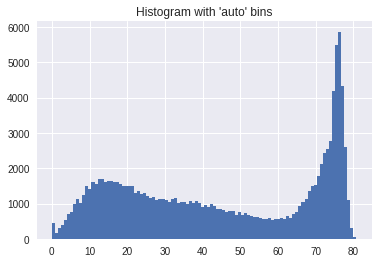

In [269]:
import itertools
len(set(itertools.chain(*list_of_pairs)))

351

In [271]:
import itertools
len(set(itertools.chain(*list_of_rep)))

351

In [273]:
equi_classes=find_classes(list_of_rep)

In [274]:
len(equi_classes)

69

In [275]:
from nltk import FreqDist

In [276]:
results=[]
for group in equi_classes:
    results.append([sorted_features[x] for x in group])

In [312]:
def choose_best_res(record):
    candiates=[(x[0],x[1],x[2],-len(x[1].split(';'))) for x in record if not x[1][0:7]=='Eukarya']
    taxa_freq=FreqDist([y[1] for y in candiates]).most_common()
    final=[]
    for taxa, freq in taxa_freq:
        min_idx = np.argmin([rec[2] for rec in record if rec[1]==taxa])
        rep_marker=[rec[0] for rec in record if rec[1]==taxa][min_idx]
        pval=np.median([rec[2] for rec in record if rec[1]==taxa])
        direction=taxa[-1]
        taxlevel=len(taxa[0:-1].split(';'))-np.sum([1 if isGenomeName(name) else 0 for name in taxa[0:-1].split(';')])
        final.append([taxa[0:-1],rep_marker,direction, taxlevel, freq,pval])
    candidates=sorted(final, key=lambda element: (-element[3],element[5],element[4]))
    return candidates[0]

In [325]:
def check_results(results):
    final_results=[]
    for x in results:
        if len(x)>1:
            final_results.append(choose_best_res(x))
        else:
            x=x[0]
            taxa=x[1][0:-1]
            seq=x[0]
            d=x[1][-1]
            length=len(taxa.split(';'))-np.sum([1 if isGenomeName(name) else 0 for name in taxa.split(';')])
            final_results.append([taxa,seq,d,length,1,x[2]])
    candidates=sorted(final_results, key=lambda element: (element[2],-element[3],element[5],element[4]))
    return candidates

In [327]:
len(check_results(results))

69